In [1]:
#_____import packages______
from astropy.io import fits
import numpy as np
import math
import time
import sys
from astropy.table import Table
from astropy import constants as const
from astropy import units as u    
 
from galpy.util import bovy_coords, bovy_conversion
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel, estimateDeltaStaeckel, UnboundError
from galpy.potential import plotDensities, plotPotentials, plotRotcurve, turn_physical_on
from galpy.potential import evaluateSurfaceDensities

import McMillan


import corner

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import rcParams 
rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.width'] = 1.5

  Referenced from: /Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy_interppotential_c.cpython-36m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy_actionAngle_c.cpython-36m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy_actionAngle_c.cpython-36m-darwin.so
  Reason: image not found' 
/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:190: RuntimeWarning: divide by zero encountered in double_scalars
  ts= lambda R, trd=rd, trm=rm: numpy.exp(-trm/R-R/trd)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:194: RuntimeWarning: divide by zero encountered in double_scalars
  ((trm/R**2.-1./trd)**2.-2.*trm/R**3.)*numpy.exp(-trm/R-R/trd)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:194: RuntimeWarning: invalid value encounte

In [2]:
## read in Helmi's data for Fig 1
source_id1,vx,vy,vz,En,Lz1,flag_enc = np.genfromtxt('../../Gaia/41586_2018_625_MOESM1_ESM.csv', delimiter=',', unpack=True, skip_header=1)

In [3]:
source_id5,l,b,parallax,parallax_error,mu_l,mu_b,Lz5,flag_stars = np.genfromtxt('../../Gaia/41586_2018_625_MOESM5_ESM.csv', delimiter = ',', unpack = True, skip_header=1)                                                                        
                                                                               
                                                                               

(array([  3.40000000e+01,   1.29000000e+02,   2.40900000e+03,
          1.30230000e+04,   1.82870000e+04,   1.44850000e+04,
          3.80000000e+01,   1.10000000e+01,   8.00000000e+00,
          3.00000000e+00]),
 array([-3949.643001  , -2763.54665388, -1577.45030676,  -391.35395964,
          794.74238748,  1980.8387346 ,  3166.93508171,  4353.03142883,
         5539.12777595,  6725.22412307,  7911.32047019]),
 <a list of 10 Patch objects>)

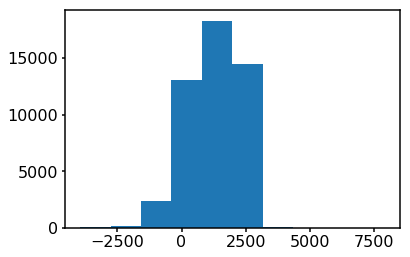

In [4]:
plt.hist(Lz1)

In [5]:
source_id1 = source_id1.astype(int)
source_id5 = source_id5.astype(int)

In [6]:
i_vels = np.isin(source_id1[flag_enc ==2], source_id5[flag_stars ==0]) # to use w/ source_id1 and its things t/w/ flag_enc == 2
i_pos = np.isin(source_id5[flag_stars ==0], source_id1[flag_enc ==2]) # to use w/ source_id5 and its things t/w/ flag_stars == 0

(array([    4.,     7.,    24.,    17.,    43.,    98.,   282.,   514.,
         1250.,  2405.]),
 array([-3949.643001  , -3539.69601682, -3129.74903264, -2719.80204846,
        -2309.85506428, -1899.9080801 , -1489.96109591, -1080.01411173,
         -670.06712755,  -260.12014337,   149.82684081]),
 <a list of 10 Patch objects>)

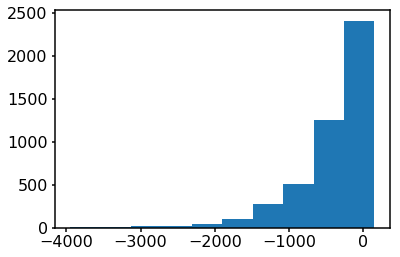

In [7]:
plt.hist(Lz1[flag_enc ==2])

(array([   82.,   134.,   133.,   214.,   243.,   380.,   531.,   738.,
          964.,  1006.]),
 array([-1449.94758653, -1289.9701438 , -1129.99270106,  -970.01525833,
         -810.03781559,  -650.06037286,  -490.08293013,  -330.10548739,
         -170.12804466,   -10.15060192,   149.82684081]),
 <a list of 10 Patch objects>)

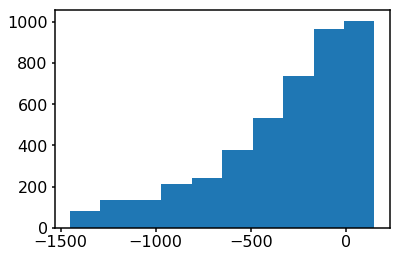

In [8]:
plt.hist(Lz1[flag_enc ==2][i_vels])

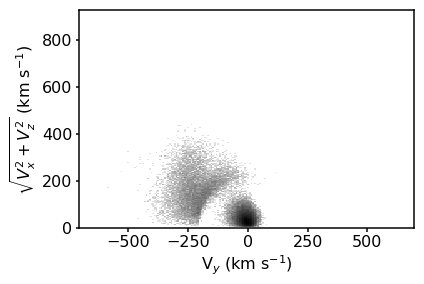

In [49]:
y_toomre = np.sqrt(vx**2 + vz**2)
fig,ax = plt.subplots()

ax.hist2d(vy-232., y_toomre, bins = 201, norm = colors.LogNorm(), cmap = plt.cm.binary)
#ax.plot(vy[flag_enc == 2][i_vels], y_toomre[flag_enc ==2][i_vels], 'r.')
ax.set_xlabel('V$_y$ (km s$^{-1}$)')
ax.set_ylabel('$\sqrt{V_x^2 + V_z^2}$ (km s$^{-1}$)')

plt.show()

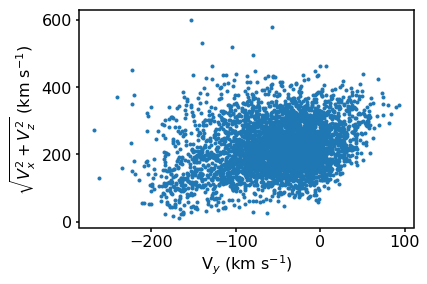

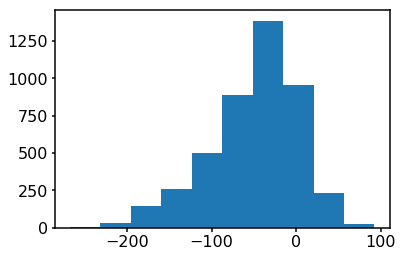

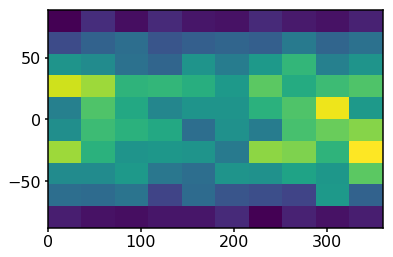

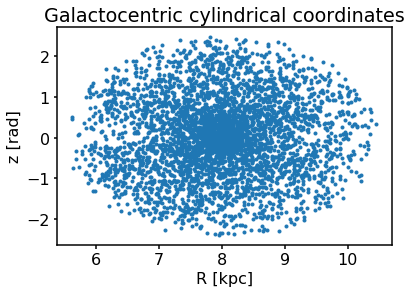

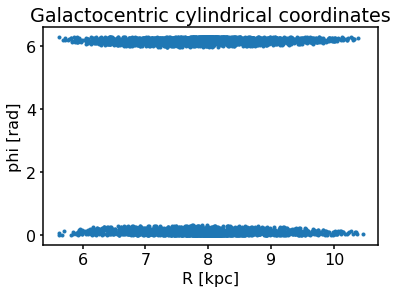

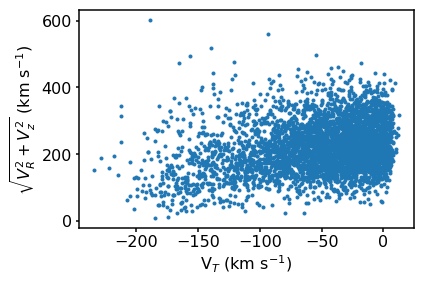

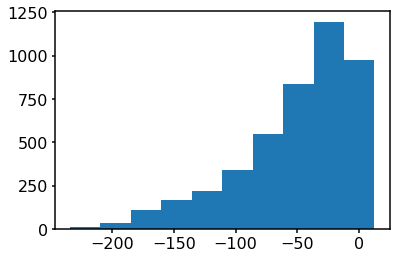

In [50]:
## we need R,vR,vT,z,vz
l_enc = l[flag_stars ==0][i_pos]
b_enc = b[flag_stars ==0][i_pos]
parallax_enc = parallax[flag_stars ==0][i_pos]
vx_enc = vx[flag_enc == 2][i_vels]
vy_enc = vy[flag_enc == 2][i_vels]
vz_enc = vz[flag_enc == 2][i_vels]

y_toomre = np.sqrt(vx_enc**2 + vz_enc**2)
fig,ax = plt.subplots()

ax.plot(vy_enc, y_toomre, '.')#, bins = 201, norm = colors.LogNorm(), cmap = plt.cm.binary)
#ax.plot(vy[flag_enc == 2], y_toomre[flag_enc ==2], 'r.')
ax.set_xlabel('V$_y$ (km s$^{-1}$)')
ax.set_ylabel('$\sqrt{V_x^2 + V_z^2}$ (km s$^{-1}$)')

plt.show()
plt.hist(vy_enc)
plt.show()
#Galactocentric position of the Sun:
X_gc_sun_kpc = 8.    #[kpc]
Z_gc_sun_kpc = 0.025 #[kpc]

#Galactocentric velocity of the Sun (Schoenrich et al. 2010):
U_LSR_sun_kms = 11.1        # = U [kms]
V_LSR_sun_kms = 12.24       # = V [kms]
W_LSR_sun_kms = 7.25        # = W [kms]
vX_gc_sun_kms = -U_LSR_sun_kms        # = -U              [kms]
vY_gc_sun_kms = V_LSR_sun_kms+220.    # = V+v_circ(R_Sun) [kms]
vZ_gc_sun_kms = W_LSR_sun_kms         # = W               [kms]
# distance
d_kpc_enc = 1./parallax_enc

plt.hist2d(l_enc, b_enc)
plt.show()
# (l,b,d) --> Galactocentric cartesian coordinates (x,y,z):
xyz = bovy_coords.lbd_to_XYZ(
                l_enc,b_enc,
                d_kpc_enc,
                degree=True)
x_HC_kpc = xyz[:,0]
y_HC_kpc = xyz[:,1]
z_HC_kpc = xyz[:,2]

# (x,y,z) --> Galactocentric cylindrical coordinates (R,z,phi):
Rzphi= bovy_coords.XYZ_to_galcencyl(
                x_HC_kpc, y_HC_kpc, z_HC_kpc, 
                Xsun=X_gc_sun_kpc,Zsun=Z_gc_sun_kpc
                )
R_kpc_enc   = Rzphi[:,0]
phi_rad_enc = Rzphi[:,1]
z_kpc_enc   = Rzphi[:,2]

plt.plot(R_kpc_enc, z_kpc_enc, '.')
plt.xlabel('R [kpc]')
plt.ylabel('z [rad]')
plt.title('Galactocentric cylindrical coordinates')
plt.show()

plt.plot(R_kpc_enc, phi_rad_enc, '.')
plt.xlabel('R [kpc]')
plt.ylabel('phi [rad]')
plt.title('Galactocentric cylindrical coordinates')
plt.show()

#b. convert velocities (pm_ra,pm_dec,vlos) to (vR,vz,vT)

# (vx,vy,vz) & (x,y,z) --> (vR,vT,vz):
vRvTvZ = bovy_coords.vxvyvz_to_galcencyl(
                vx_enc, 
                vy_enc-232., 
                vz_enc, 
                R_kpc_enc,
                phi_rad_enc, 
                z_kpc_enc,
                Xsun=X_gc_sun_kpc,Zsun=Z_gc_sun_kpc,
                vsun=[vX_gc_sun_kms,vY_gc_sun_kms,vZ_gc_sun_kms], 
                galcen=True
                )
vR_kms_enc = vRvTvZ[:,0]
vT_kms_enc = vRvTvZ[:,1]
vz_kms_enc = vRvTvZ[:,2]

y_toomre = np.sqrt(vR_kms_enc**2 + vz_kms_enc**2)
fig,ax = plt.subplots()

ax.plot(vT_kms_enc, y_toomre, '.')# bins = 201, norm = colors.LogNorm(), cmap = plt.cm.binary)
#ax.plot(vT_kms_enc[flag_enc == 2], y_toomre[flag_enc ==2], 'r.')
ax.set_xlabel('V$_T$ (km s$^{-1}$)')
ax.set_ylabel('$\sqrt{V_R^2 + V_z^2}$ (km s$^{-1}$)')

plt.show()
plt.hist(vT_kms_enc)
plt.show()

In [51]:
fix_R0_kpc = 8.
fix_v0_kms = 232.
R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc_enc / fix_R0_kpc, vR_kms_enc / fix_v0_kms, vT_kms_enc / fix_v0_kms, z_kpc_enc / fix_R0_kpc, vz_kms_enc / fix_v0_kms


In [52]:
delta = estimateDeltaStaeckel(MWPotential2014,R_kpc_enc,z_kpc_enc)
aAS= actionAngleStaeckel(pot=MWPotential2014,delta=delta)

In [53]:
jR_galpy = np.full(len(R_galpy), np.nan)
lz_galpy = np.full(len(R_galpy), np.nan)
jz_galpy = np.full(len(R_galpy), np.nan)

for ii in range(len(R_galpy)):
    try: 
        jR_galpy[ii], lz_galpy[ii], jz_galpy[ii] = aAS(R_galpy[ii], vR_galpy[ii], vT_galpy[ii], z_galpy[ii], vz_galpy[ii])

    except(ValueError, UnboundError): continue


jR_enc = jR_galpy[np.isfinite(jR_galpy)] * fix_R0_kpc * fix_v0_kms 
lz_enc = lz_galpy[np.isfinite(lz_galpy)] * fix_R0_kpc * fix_v0_kms 
jz_enc = jz_galpy[np.isfinite(jz_galpy)] * fix_R0_kpc * fix_v0_kms 

(array([  86.,  136.,  149.,  219.,  260.,  409.,  587.,  834.,  980.,  762.]),
 array([-1472.78930178, -1316.24886145, -1159.70842113, -1003.1679808 ,
         -846.62754048,  -690.08710015,  -533.54665983,  -377.0062195 ,
         -220.46577918,   -63.92533885,    92.61510147]),
 <a list of 10 Patch objects>)

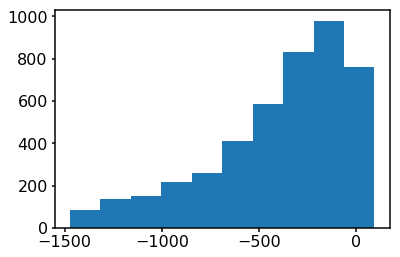

In [54]:
plt.hist(lz_enc)

In [56]:
ids_enc = source_id1[flag_enc == 2][i_vels][np.isfinite(jR_galpy)]
np.savetxt('../files/Enceladus_MWPotential_actions.txt', (ids_enc, jR_enc, lz_enc, jz_enc), header = 'SourceId\tjR [kpc km/s]\tlz [kpc km/s]\tjz [kpc km/s]')

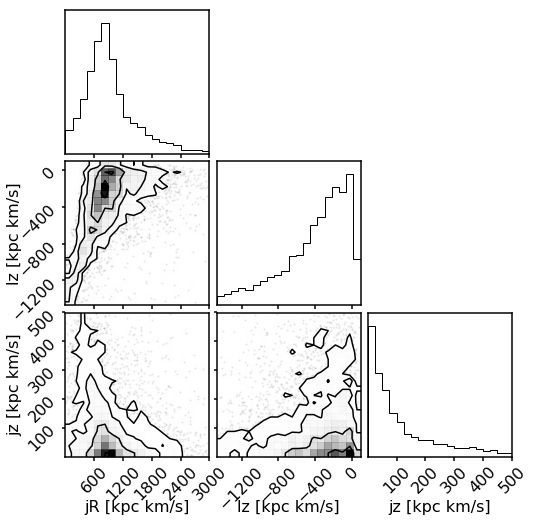

In [57]:

data_cut = (jR_enc<=3000. )* (jz_enc<= 500)
data = np.vstack([jR_enc[data_cut], lz_enc[data_cut], jz_enc[data_cut]])
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black')
figure.savefig('../plots/Enceladus_MWPotential_actions.png', dpi = 300, bbox_inches='tight')

In [58]:
mcm17= McMillan.McMillan2017


In [59]:
delta = estimateDeltaStaeckel(mcm17,R_kpc_enc/fix_R0_kpc ,z_kpc_enc/fix_R0_kpc)

  Referenced from: /Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy_integrate_c.cpython-36m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy_integrate_c.cpython-36m-darwin.so
  Reason: image not found' 


In [ ]:
aAS= actionAngleStaeckel(pot=mcm17,delta=delta)

In [ ]:
jR_galpy = np.full(len(R_galpy), np.nan)
lz_galpy = np.full(len(R_galpy), np.nan)
jz_galpy = np.full(len(R_galpy), np.nan)

for ii in range(len(R_galpy)):
    if (ii%100 == 1): print(ii)
    try: 
        jR_galpy[ii], lz_galpy[ii], jz_galpy[ii] = aAS(R_galpy[ii], vR_galpy[ii], vT_galpy[ii], z_galpy[ii], vz_galpy[ii])

    except(ValueError, UnboundError, ZeroDivisionError): continue


jR_enc = jR_galpy[np.isfinite(jR_galpy)] * fix_R0_kpc * fix_v0_kms 
lz_enc = lz_galpy[np.isfinite(lz_galpy)] * fix_R0_kpc * fix_v0_kms 
jz_enc = jz_galpy[np.isfinite(jz_galpy)] * fix_R0_kpc * fix_v0_kms 

ids_enc = source_id1[flag_enc == 2][i_vels][np.isfinite(jR_galpy)]
np.savetxt('../files/Enceladus_McMillan17_actions.txt', (ids_enc, jR_enc, lz_enc, jz_enc), header = 'SourceId\tjR [kpc km/s]\tlz [kpc km/s]\tjz [kpc km/s]')

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/SCFPotential.py:225: RuntimeWarning: overflow encountered in power
  phi[:,:] = - (r*a)**l/ ((a + r)**(2*l + 1.)) * CC[:,:]* (4*nu.pi)**0.5

/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/SCFPotential.py:225: RuntimeWarning: invalid value encountered in true_divide
  phi[:,:] = - (r*a)**l/ ((a + r)**(2*l + 1.)) * CC[:,:]* (4*nu.pi)**0.5

3901
4001
4101
4201
4301
4401


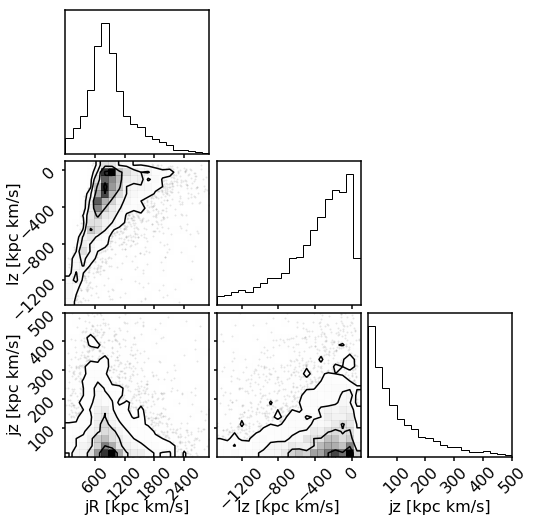

In [ ]:
data_cut = (jR_enc<=3000. )* (jz_enc<= 500)
data = np.vstack([jR_enc[data_cut], lz_enc[data_cut], jz_enc[data_cut]])
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black')            
figure.savefig('../plots/Enceladus_McMillan17_actions.png', dpi = 300, bbox_inches='tight')

In [ ]:
from galpy.potential import MiyamotoNagaiPotential, HernquistPotential, LogarithmicHaloPotential

def galpy_potential(a_disk = 6.5, b_disk = 0.26, c_bulge = 0.7, q_halo = 1., M_disk = 6.3e10, M_bulge = 2.1e10, v_halo = 220.):
    Phi_disk = MiyamotoNagaiPotential(amp = const.G * M_disk * u.Msun, a = 6.5 * u.kpc, b = 0.26 * u.kpc)
    Phi_bulge = HernquistPotential(amp = const.G * M_bulge * u.Msun, a = c_bulge * u.kpc)
    Phi_halo = LogarithmicHaloPotential(amp = v_halo**2 * (u.km/u.s)**2, q = 0.8)
    Phi_tot = [Phi_halo, Phi_bulge, Phi_disk]
    return(Phi_tot)
    
def potential(R, z, v_halo = 173.2, d = 12., M_disk = 6.3, a_d = 6.5, b_d = 0.26, M_bulge = 2.1, c_b = 0.7):
    r = np.sqrt(R**2 + z**2)
    Phi_halo  = (v_halo * u.km/u.s) **2. * np.log(1. + ((R * u.kpc)**2 / (d * u.kpc)**2) + ((z * u.kpc)**2 / (d * u.kpc)**2)) #km^2/s^2
    Phi_disk  = - const.G * M_disk * 1e10 * u.Msun / np.sqrt((R * u.kpc)**2 + (a_d * u.kpc + np.sqrt((z*u.kpc)**2 + (b_d * u.kpc)**2))**2)
    Phi_bulge = - const.G * M_bulge *1e10 * u.Msun / (r * u.kpc + c_b * u.kpc)
    Phi_tot = Phi_halo + Phi_bulge + Phi_disk
    return(Phi_tot)


In [ ]:
pot = galpy_potential()

In [ ]:
delta = estimateDeltaStaeckel(pot,R_kpc_enc/fix_R0_kpc ,z_kpc_enc/fix_R0_kpc)

In [ ]:
delta 

6.2434905368393601

In [ ]:
aAS= actionAngleStaeckel(pot=pot,delta=delta)

In [ ]:
jR_galpy = np.full(len(R_galpy), np.nan)
lz_galpy = np.full(len(R_galpy), np.nan)
jz_galpy = np.full(len(R_galpy), np.nan)

for ii in range(len(R_galpy)):
    if (ii%100 == 1): print(ii)
    try: 
        jR_galpy[ii], lz_galpy[ii], jz_galpy[ii] = aAS(R_galpy[ii], vR_galpy[ii], vT_galpy[ii], z_galpy[ii], vz_galpy[ii])

    except(ValueError, UnboundError, ZeroDivisionError): continue


jR_enc = jR_galpy[np.isfinite(jR_galpy)] * fix_R0_kpc * fix_v0_kms 
lz_enc = lz_galpy[np.isfinite(lz_galpy)] * fix_R0_kpc * fix_v0_kms 
jz_enc = jz_galpy[np.isfinite(jz_galpy)] * fix_R0_kpc * fix_v0_kms 

ids_enc = source_id1[flag_enc == 2][i_vels][np.isfinite(jR_galpy)]
np.savetxt('../files/Enceladus_Helmi17_v220_actions.txt', (ids_enc, jR_enc, lz_enc, jz_enc), header = 'SourceId\tjR [kpc km/s]\tlz [kpc km/s]\tjz [kpc km/s]')

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401


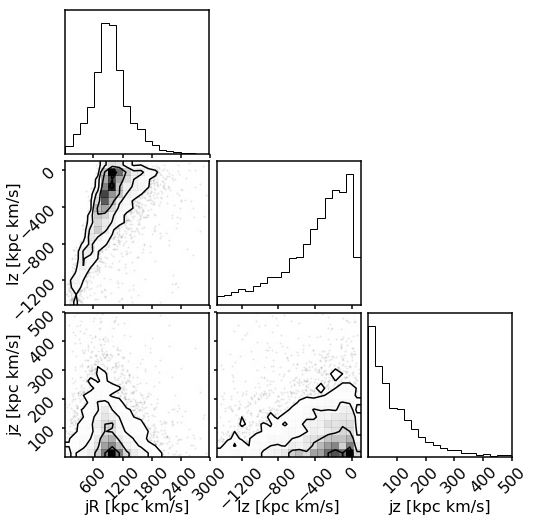

In [ ]:
data_cut = (jR_enc<=3000. )* (jz_enc<= 500)
data = np.vstack([jR_enc[data_cut], lz_enc[data_cut], jz_enc[data_cut]])
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black')            
figure.savefig('../plots/Enceladus_Helmi17_v220kms_actions.png', dpi = 300, bbox_inches='tight')

In [ ]:
pot = LogarithmicHaloPotential(250 **2. * u.km**2/u.s**2, q = 0.8)
delta = estimateDeltaStaeckel(pot,R_kpc_enc/fix_R0_kpc ,z_kpc_enc/fix_R0_kpc)
print(delta)
aAS= actionAngleStaeckel(pot=pot,delta=delta)

jR_galpy = np.full(len(R_galpy), np.nan)
lz_galpy = np.full(len(R_galpy), np.nan)
jz_galpy = np.full(len(R_galpy), np.nan)

for ii in range(len(R_galpy)):
    if (ii%100 == 1): print(ii)
    try: 
        jR_galpy[ii], lz_galpy[ii], jz_galpy[ii] = aAS(R_galpy[ii], vR_galpy[ii], vT_galpy[ii], z_galpy[ii], vz_galpy[ii])

    except(ValueError, UnboundError, ZeroDivisionError): continue


jR_enc = jR_galpy[np.isfinite(jR_galpy)] * fix_R0_kpc * fix_v0_kms 
lz_enc = lz_galpy[np.isfinite(lz_galpy)] * fix_R0_kpc * fix_v0_kms 
jz_enc = jz_galpy[np.isfinite(jz_galpy)] * fix_R0_kpc * fix_v0_kms 

ids_enc = source_id1[flag_enc == 2][i_vels][np.isfinite(jR_galpy)]
np.savetxt('../files/Enceladus_LogHalo_v250_actions.txt', (ids_enc, jR_enc, lz_enc, jz_enc), header = 'SourceId\tjR [kpc km/s]\tlz [kpc km/s]\tjz [kpc km/s]')

4.81078323688
1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401


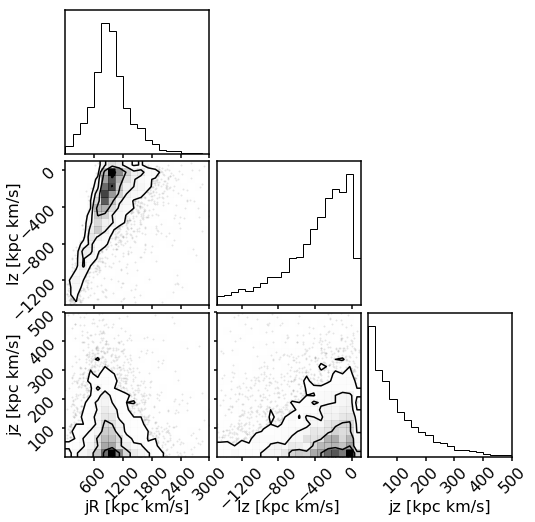

In [ ]:
data_cut = (jR_enc<=3000. )* (jz_enc<= 500)
data = np.vstack([jR_enc[data_cut], lz_enc[data_cut], jz_enc[data_cut]])
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black')            
figure.savefig('../plots/Enceladus_LogHalo_v250kms_actions.png', dpi = 300, bbox_inches='tight')

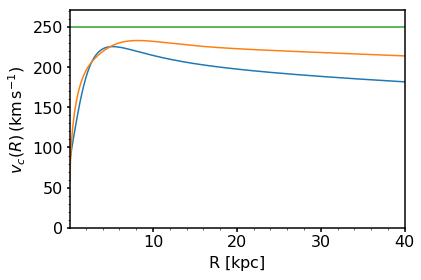

In [ ]:
turn_physical_on(MWPotential2014)
plotRotcurve(MWPotential2014, xlabel = '\mathrm{R\ [kpc]}')
plotRotcurve(mcm17, overplot = True)
plotRotcurve(pot, overplot = True)

In [ ]:
R =  np.arange(0,26,1)
sigma_H = []
sigma_McM = []
sigma_MW14 = []
for i in range(26):
    sigma_H.append(evaluateSurfaceDensities(pot,i * u.kpc, 0.5* u.kpc))
    sigma_McM.append(evaluateSurfaceDensities(mcm17,i * u.kpc, 0.5* u.kpc))
    sigma_MW14.append(evaluateSurfaceDensities(MWPotential2014,i * u.kpc, 0.5* u.kpc))
    

/Users/smilanov/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/TwoPowerSphericalPotential.py:975: RuntimeWarning: divide by zero encountered in arctan
  +z/(r+self.a)/(R**2.-self.a**2.)).real/2./numpy

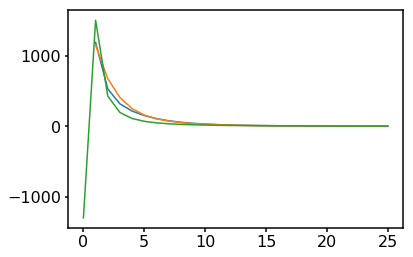

In [75]:
plt.plot(R, sigma_McM)
plt.plot(R, sigma_MW14)
plt.plot(R, sigma_H)
